<a href="https://colab.research.google.com/github/jeonghojo00/DogsAndCats/blob/main/imageclassification_dogsandcats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Select Runtime Type

## GPU

In [1]:
# Run only when Using GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May  9 06:05:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                  N/A |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


# Dogs and Cats classification

## 0. Setup

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change directory to the package folder
%cd '/content/drive/MyDrive/Colab Notebooks/DB/dogs_and_cats'
# Verify the contents of the current folder
!ls

/content/drive/MyDrive/Colab Notebooks/DB/dogs_and_cats
model  result  test  test.zip  train  train.zip


In [5]:
# General
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import time
import copy
import pickle
import glob

# Pytorch libraries for models and input
import torch
import torchvision 
from torchvision import models
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from torchvision.transforms import transforms, ToTensor

In [6]:
# Execute only when only zip files are present
'''
from zipfile import ZipFile

with ZipFile('./train.zip', 'r') as zip:
    #zip.printdir()
    zip.extractall()
    print("Train Zip Extract Done")
    
with ZipFile('./test.zip', 'r') as zip:
    #zip.printdir()
    zip.extractall()
    print("Test Zip Extract Done")
'''

'\nfrom zipfile import ZipFile\n\nwith ZipFile(\'./train.zip\', \'r\') as zip:\n    #zip.printdir()\n    zip.extractall()\n    print("Train Zip Extract Done")\n    \nwith ZipFile(\'./test.zip\', \'r\') as zip:\n    #zip.printdir()\n    zip.extractall()\n    print("Test Zip Extract Done")\n'

## 1. Data Preparation

In [7]:
train_path = './train'
test_path = './test'

train_list = glob.glob(os.path.join(train_path,'*.jpg'))
test_list = glob.glob(os.path.join(test_path,'*.jpg'))

print("{} Train images and {} Test images".format(len(train_list), len(test_list)))
print("train_list contains followings...")
print(*train_list[:5],sep='\n')

25000 Train images and 12500 Test images
train_list contains followings...
./train/dog.9099.jpg
./train/dog.91.jpg
./train/dog.910.jpg
./train/dog.9100.jpg
./train/dog.9101.jpg


In [8]:
from sklearn.model_selection import train_test_split

train_list, val_list = train_test_split(train_list, test_size=0.2)

In [9]:
category = {'dog': 1,
           'cat': 0}
IMG_SIZE = 224
BATCH_SIZE = 32

In [10]:
#data Augumentation
train_transforms =  transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0 , 0 , 0) , (1 , 1 , 1)),
    ])

val_transforms = transforms.Compose([
        transforms.ToPILImage(),    
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0 , 0 , 0) , (1 , 1 , 1)),
    ])


test_transforms = transforms.Compose([ 
        transforms.ToPILImage(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0 , 0 , 0) , (1 , 1 , 1))
    ])

In [11]:
class dataset(Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform
    
    def __len__(self):
        self.filelength = len(self.image_files)
        return self.filelength
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = cv2.imread(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        else:
            label = 0

        return img_transformed, label

In [12]:
train_data = dataset(train_list, train_transforms)
print("{} train images are loaded".format(len(train_data)))
val_data = dataset(val_list, val_transforms)
print("{} val images are loaded".format(len(val_data)))
test_data = dataset(test_list, test_transforms)
print("{} test images are loaded".format(len(test_data)))

20000 train images are loaded
5000 val images are loaded
12500 test images are loaded


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  import sys


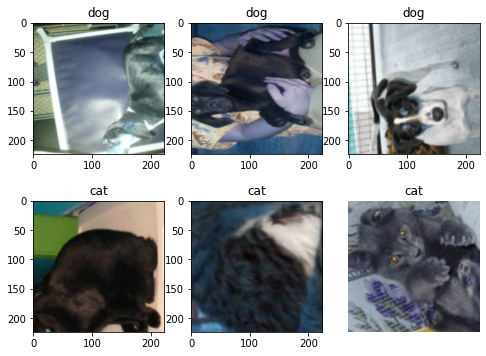

In [ ]:
random_idx = np.random.randint(1, len(train_data), size = 6)
fig = plt.figure(figsize=(8, 6))
i = 1
for idx in random_idx:
    ax = fig.add_subplot(2, 3, i)
    a_img = train_data[idx][0]
    plt.imshow(np.squeeze(a_img).T)
    if train_data[idx][1] == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    i+=1

plt.axis('off')
plt.show()

In [13]:
train_dl = DataLoader(train_data, batch_size = BATCH_SIZE)
print("{} batches with {} batch size in train_dl".format(len(train_dl), BATCH_SIZE))
val_dl = DataLoader(val_data, batch_size = BATCH_SIZE)
print("{} batches with {} batch size in val_dl".format(len(val_dl), BATCH_SIZE))
test_dl = DataLoader(test_data, batch_size = BATCH_SIZE)
print("{} batches with {} batch size in test_dl".format(len(test_dl), BATCH_SIZE))

625 batches with 32 batch size in train_dl
157 batches with 32 batch size in val_dl
391 batches with 32 batch size in test_dl


##2. Testing which batch size works for the current platform and if the training flow goes well

In [ ]:
# Load a model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(DEVICE)

model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
optimizer = torch.optim.Adam(params = model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

Testing if input and output comes out properly

In [ ]:
epoch_loss = 0
epoch_acc = 0

a_img, a_label = next(iter(train_dl))
a_img = a_img.to(DEVICE)
a_label = a_label.to(DEVICE)

output = model(a_img)
print("Output in shape: ", output.shape)
print("Output")
print(output.argmax(dim=1))
print("Correct Label")
print(a_label)

loss = criterion(output, a_label)
print("Loss: ", loss.item())

acc = (output.argmax(dim=1) == a_label).sum().item()
print("Correctness: ", acc, ", Accuracy: ", acc/len(a_img))

epoch_loss = loss.item()
epoch_acc = acc

optimizer.zero_grad()
loss.backward()
optimizer.step()

print('Epoch : {}, train accuracy : {}, train loss : {}'.format(1, epoch_acc, epoch_loss))

Output in shape:  torch.Size([32, 2])
Output
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
Correct Label
tensor([1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
Loss:  0.6445540189743042
Correctness:  17 , Accuracy:  0.53125
Epoch : 1, train accuracy : 17, train loss : 0.6445540189743042


##3. Hyper-parameter tuning study

### Define Train and Evaluate Function for Study

In [ ]:
# Train and evaluate the accuarcy of neural network model
def train_and_evaluate(train_dl, val_dl, train_len, val_len, params, model, trial):

    criterion = nn.CrossEntropyLoss()
    # Configure optimizer
    optimizer = getattr(torch.optim, params["optimizer_name"])(model.parameters(), lr=params["learning_rate"])

    for epoch_num in range(10):
        epoch_loss = 0
        epoch_acc = 0

        for train_img, train_label in train_dl:

            train_img = train_img.to(DEVICE)
            train_label = train_label.to(DEVICE)
            
            # Forward
            train_output = model(train_img)
            train_loss = criterion(train_output, train_label)
            train_acc = (train_output.argmax(dim=1) == train_label).sum().item()
            
            epoch_loss += train_loss.item()
            epoch_acc += train_acc
            
            # Backward
            optimizer.zero_grad()
            train_loss.backward()
            
            # Gradient Descent or Adam step
            optimizer.step()

    
        with torch.no_grad():
            epoch_val_acc = 0
            epoch_val_loss = 0
            
            for img, label in val_dl:
                img = img.to(DEVICE)
                label = label.to(DEVICE)
                
                val_output = model(img)
                val_loss = criterion(val_output, label)
                val_acc = (val_output.argmax(dim=1) == label).sum().item()
                
                epoch_val_acc += val_acc
                epoch_val_loss += val_loss
            
        accuracy = epoch_val_acc/val_len
            
        # Add prune mechanism
        trial.report(accuracy, epoch_num)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

### Run a study with a selected model

In [ ]:
# Define a set of hyperparameter values, build the model, train the model, and evaluate the accuracy 
def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
              'optimizer_name': trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop", "SGD"]),
              }

    # Get a model
    model = models.resnet50(pretrained=False, num_classes=2).to(DEVICE)
    
    accuracy = train_and_evaluate(train_dl, val_dl, len(train_list), len(val_list), params, model, trial)

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=20)

In [ ]:
best_trial = study.best_trial
print("Best Trial with Parameters")
for key, value in best_trial.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
fig = optuna.visualization.plot_intermediate_values(study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_slice(study)
fig.show()

In [ ]:
joblib.dump(study, "study_dogs_cats_resnet50_220505.pkl")

In [ ]:
loaded_study = joblib.load("study_dogs_cats_resnet50_220505.pkl")
print("Best trial until now:")
print(" Value: ", loaded_study.best_trial.value)
print(" Params: ")
for key, value in loaded_study.best_trial.params.items():
    print(f"    {key}: {value}")

##4. Train Model

### Define Train and Test Functions

In [14]:
def train_model(model, model_path, res_path, criterion, optimizer, scheduler, num_epochs=1):
    print("Training...")
    since = time.time()

    best_model_state = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    res = {}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        epoch_loss = 0.0
        epoch_acc = 0.0
        epoch_correct = 0
        
        for idx, (img, label) in enumerate(train_dl):
            img = img.to(DEVICE)
            label = label.to(DEVICE)
            
            # Forward
            output = model(img)
            loss = criterion(output, label)
            acc = (output.argmax(dim=1) == label).sum().item()
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient Descent or Adam step
            optimizer.step()
            
            epoch_loss += (loss.item()/len(train_data))
            epoch_acc += (acc/len(train_data))
            
        print(f'Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        res[epoch+1] = {"Train_Loss": epoch_loss, 
                        "Train_Acc": epoch_acc}
        scheduler.step()

        with torch.no_grad():
            epoch_val_acc = 0.0
            epoch_val_loss = 0.0
            epoch_val_correct = 0
            
            for img, label in val_dl:
                img = img.to(DEVICE)
                label = label.to(DEVICE)
                
                val_output = model(img)
                val_loss = criterion(val_output, label)
                val_acc = (val_output.argmax(dim=1) == label).sum().item()
                
                epoch_val_acc += (val_acc/len(val_data))
                epoch_val_loss += (val_loss.item()/len(val_data))
                
            print(f'Validation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.4f}')
            res[epoch+1] = {"Val_Loss": epoch_val_loss, 
                            "Val_Acc": epoch_val_acc}
        
            if epoch_val_acc > best_acc:
                best_acc = epoch_val_acc
                best_model_state = copy.deepcopy(model.state_dict())
                if not os.path.isdir("model"):
                    os.mkdir("model")
                torch.save(model.state_dict(), model_path)
                print("Model Saved")
    
    # When Training is completed
    time_elapsed = time.time() - since
    print(f'Train completed in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best Val Accuracy: {best_acc:.4f}')

    # Save result in pickle
    with open(res_path, 'wb') as f:
        pickle.dump(res, f)
    
    # Return the model with weights of the best accuracy
    model.load_state_dict(best_model_state)
    return model


In [15]:
def test_model(model, model_path):
    print("Testing...")
    since = time.time()  
    total_correct = 0

    # Load Model
    model.load_state_dict(torch.load(model_path))

    with torch.no_grad():
        for img, label in test_dl:
            img = img.to(DEVICE)
            label = label.to(DEVICE)
            output = model(img)

            acc = (output.argmax(dim=1) == label).sum().item()
            total_correct += acc

    # When Testing is completed
    time_elapsed = time.time() - since
    print(f'Test completed in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Test Accuracy: {total_correct/len(test_data):.4f}')


### Custom CNN

Calculate the number of nodes before the Linear Layer, which will transformed into the number of classes for its output

In [ ]:
import math 
def afterConv(n_in, k, p, s):
    n_out = int(math.ceil((n_in + 2*p - k)/s))+1
    return n_out

n_in = 224
k, p, s = 3, 1, 1
n_in = afterConv(n_in, k, p, s)
print("After first Convolutional Layer: {}".format(n_in))

k, p, s = 2, 0, 2
n_in = afterConv(n_in, k, p, s)
print("After max pooling Layer: {}".format(n_in))

k, p, s = 3, 1, 1
n_in = afterConv(n_in, k, p, s)
print("After second Convolutional Layer: {}".format(n_in))

k, p, s = 2, 0, 2
n_in = afterConv(n_in, k, p, s)
print("After max pooling Layer: {}".format(n_in))

After first Convolutional Layer: 224
After max pooling Layer: 112
After second Convolutional Layer: 112
After max pooling Layer: 56


Typical Convolution neural network consists of

[INPUT] 

→[CONV 1] → [BATCH NORM] → [ReLU] → [POOL 1]

→ [CONV 2] → [BATCH NORM] → [ReLU] → [POOL 2]

→ [FC LAYER] → [RESULT]

Mishra, Mayank (2020) Convolutional Neural Networks, Explained [Source code]. https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Cnn(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 2, image_size = 224):
        super(Cnn, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size = 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*56*56, num_classes)


    def forward(self, x):
        out = self.layer1(x)
        out = self.pool(out)
        out = self.layer2(out)
        out = self.pool(out)
        out = self.flatten(out) # or x = x.reshape(x.shape[0], -1) without flatten layer
        out = self.fc1(out)

        return out

In [ ]:
model_name = "customCNN"
LR = 0.001
EPOCHS = 20

# Load a model
model = Cnn(in_channels = 3, num_classes = 2, image_size = IMG_SIZE).to(DEVICE)

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Scheduler: Update learning rate: Every 5 epochs update Learning rate by multiply by 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define a loss function
criterion = nn.CrossEntropyLoss()

# Define a path to save the trained model
model_save_path = './model/'+model_name+'.pt'
result_save_path = './result/'+model_name+'.pkl'

In [ ]:
# Train
model = train_model(model, model_save_path, result_save_path, criterion, optimizer, scheduler, EPOCHS)

Training...
Epoch 1/20
----------
Train Loss: 0.0857, Accuracy: 0.5390
Validation Loss: 0.0342, Accuracy: 0.5804
Model Saved
Epoch 2/20
----------
Train Loss: 0.0320, Accuracy: 0.5596
Validation Loss: 0.0241, Accuracy: 0.5858
Model Saved
Epoch 3/20
----------
Train Loss: 0.0216, Accuracy: 0.5940
Validation Loss: 0.0206, Accuracy: 0.6158
Model Saved
Epoch 4/20
----------
Train Loss: 0.0201, Accuracy: 0.6239
Validation Loss: 0.0199, Accuracy: 0.6270
Model Saved
Epoch 5/20
----------
Train Loss: 0.0200, Accuracy: 0.6360
Validation Loss: 0.0201, Accuracy: 0.6226
Epoch 6/20
----------
Train Loss: 0.0196, Accuracy: 0.6468
Validation Loss: 0.0197, Accuracy: 0.6456
Model Saved
Epoch 7/20
----------
Train Loss: 0.0192, Accuracy: 0.6653
Validation Loss: 0.0191, Accuracy: 0.6700
Model Saved
Epoch 8/20
----------
Train Loss: 0.0184, Accuracy: 0.6801
Validation Loss: 0.0181, Accuracy: 0.6912
Model Saved
Epoch 9/20
----------
Train Loss: 0.0180, Accuracy: 0.6952
Validation Loss: 0.0177, Accuracy: 0.

In [ ]:
# Test
test_model(model, model_save_path)

Testing...
Test completed in 45m 48s
Test Accuracy: 0.5262


### Resnet50 (without Transfer Learning)

In [ ]:
model_name = "resnet50"
LR = 0.001
EPOCHS = 20

# Load a model
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(DEVICE)

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Scheduler: Update learning rate: Every 5 epochs update Learning rate by multiply by 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Define a loss function
criterion = nn.CrossEntropyLoss()

# Define a path to save the trained model
model_save_path = './model/'+model_name+'.pt'
result_save_path = './result/'+model_name+'.pkl'

In [ ]:
# Train
model = train_model(model, model_save_path, result_save_path, criterion, optimizer, scheduler, EPOCHS)

Training...
Epoch 1/20
----------
Train Loss: 0.0218, Accuracy: 0.5902
Validation Loss: 0.0212, Accuracy: 0.6032
Model Saved
Epoch 2/20
----------
Train Loss: 0.0203, Accuracy: 0.6311
Validation Loss: 0.0197, Accuracy: 0.6472
Model Saved
Epoch 3/20
----------
Train Loss: 0.0198, Accuracy: 0.6417
Validation Loss: 0.0199, Accuracy: 0.6422
Epoch 4/20
----------
Train Loss: 0.0197, Accuracy: 0.6482
Validation Loss: 0.0189, Accuracy: 0.6732
Model Saved
Epoch 5/20
----------
Train Loss: 0.0189, Accuracy: 0.6735
Validation Loss: 0.0187, Accuracy: 0.6692
Epoch 6/20
----------
Train Loss: 0.0184, Accuracy: 0.6896
Validation Loss: 0.0176, Accuracy: 0.7076
Model Saved
Epoch 7/20
----------
Train Loss: 0.0178, Accuracy: 0.7041
Validation Loss: 0.0179, Accuracy: 0.7078
Model Saved
Epoch 8/20
----------
Train Loss: 0.0164, Accuracy: 0.7375
Validation Loss: 0.0163, Accuracy: 0.7388
Model Saved
Epoch 9/20
----------
Train Loss: 0.0159, Accuracy: 0.7489
Validation Loss: 0.0157, Accuracy: 0.7548
Model S

In [ ]:
# Test
test_model(model, model_save_path)

Testing...
Test completed in 1m 52s
Test Accuracy: 0.5134


### Resenet50 (Transfer Learning)

In [ ]:
model_name = "resnet50TL"
LR = 0.001
EPOCHS = 20

# Load a model
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(DEVICE)

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# Scheduler: Update learning rate: Every 5 epochs update Learning rate by multiply by 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Define a loss function
criterion = nn.CrossEntropyLoss()

# Define a path to save the trained model
model_save_path = './model/'+model_name+'.pt'
result_save_path = './result/'+model_name+'.pkl'

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# Train
model = train_model(model, model_save_path, result_save_path, criterion, optimizer, scheduler, EPOCHS)

Training...
Epoch 1/20
----------
Train Loss: 0.0063, Accuracy: 0.9122
Validation Loss: 0.0058, Accuracy: 0.9226
Model Saved
Epoch 2/20
----------
Train Loss: 0.0056, Accuracy: 0.9243
Validation Loss: 0.0047, Accuracy: 0.9354
Model Saved
Epoch 3/20
----------
Train Loss: 0.0054, Accuracy: 0.9268
Validation Loss: 0.0049, Accuracy: 0.9352
Epoch 4/20
----------
Train Loss: 0.0054, Accuracy: 0.9264
Validation Loss: 0.0048, Accuracy: 0.9372
Model Saved
Epoch 5/20
----------
Train Loss: 0.0053, Accuracy: 0.9275
Validation Loss: 0.0046, Accuracy: 0.9344
Epoch 6/20
----------
Train Loss: 0.0045, Accuracy: 0.9376
Validation Loss: 0.0050, Accuracy: 0.9314
Epoch 7/20
----------
Train Loss: 0.0044, Accuracy: 0.9389
Validation Loss: 0.0047, Accuracy: 0.9364
Epoch 8/20
----------
Train Loss: 0.0044, Accuracy: 0.9376
Validation Loss: 0.0046, Accuracy: 0.9374
Model Saved
Epoch 9/20
----------
Train Loss: 0.0044, Accuracy: 0.9381
Validation Loss: 0.0046, Accuracy: 0.9360
Epoch 10/20
----------
Train Lo

In [ ]:
# Test
test_model(model, model_save_path)

Testing...
Test completed in 89m 22s
Test Accuracy: 0.4970


##5. Results

In [11]:
# Load result files
result_path = './result'

result_list = glob.glob(os.path.join(result_path,'*.pkl'))
results = dict()

for filename in result_list:
    basename = os.path.basename(filename)
    a_model = os.path.splitext(basename)[0]
    with (open(filename, "rb")) as f:
        results[a_model] = pickle.load(f)

In [15]:
results["customCNN"]

{1: {'Val_Acc': 0.5804, 'Val_Loss': 0.03418294540643691},
 2: {'Val_Acc': 0.5857999999999999, 'Val_Loss': 0.024110367941856378},
 3: {'Val_Acc': 0.6158000000000001, 'Val_Loss': 0.020608111357688908},
 4: {'Val_Acc': 0.6270000000000006, 'Val_Loss': 0.019894619691371917},
 5: {'Val_Acc': 0.6225999999999999, 'Val_Loss': 0.02013082714676857},
 6: {'Val_Acc': 0.645600000000001, 'Val_Loss': 0.01970282630324363},
 7: {'Val_Acc': 0.6700000000000003, 'Val_Loss': 0.01906875426173209},
 8: {'Val_Acc': 0.6912000000000003, 'Val_Loss': 0.01811071509718895},
 9: {'Val_Acc': 0.705, 'Val_Loss': 0.01774987102150918},
 10: {'Val_Acc': 0.6976000000000002, 'Val_Loss': 0.017825168132781982},
 11: {'Val_Acc': 0.6992000000000003, 'Val_Loss': 0.01789944111704827},
 12: {'Val_Acc': 0.7074000000000004, 'Val_Loss': 0.017606870037317278},
 13: {'Val_Acc': 0.7030000000000001, 'Val_Loss': 0.01792822734117509},
 14: {'Val_Acc': 0.7202000000000003, 'Val_Loss': 0.017153823101520544},
 15: {'Val_Acc': 0.7164000000000004

In [46]:
from collections import defaultdict
# results -> each model -> Train_Loss, Train_Acc, Val_Loss, Val_Acc

models = results.keys()
Val_Acc = defaultdict(list)
Val_Loss = defaultdict(list)
eps = []

for m in models:
    for ep in results[m].keys():
        Val_Acc[m].append(results[m][ep]['Val_Acc'])
        Val_Loss[m].append(results[m][ep]['Val_Loss'])

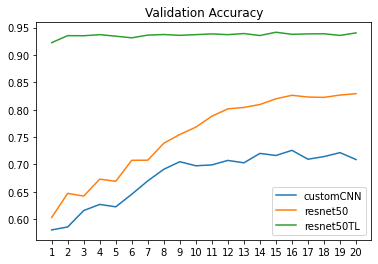

In [48]:
x_range = np.arange(1, 21, step=1)

for m in models:
    plt.plot(x_range, Val_Acc[m], label=m)
plt.title("Validation Accuracy")
plt.legend(loc='best')
plt.xticks(x_range)
plt.show()

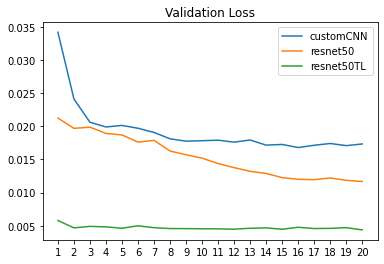

In [49]:
for m in models:
    plt.plot(x_range, Val_Loss[m], label=m)
plt.title("Validation Loss")
plt.legend(loc='best')
plt.xticks(x_range)
plt.show()

##7. Inference

In [25]:
def get_prediction(x, model: nn.Module):
    with torch.no_grad():
        probabilities = torch.softmax(model(x), dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

In [41]:
test_imgs, test_labels = next(iter(test_dl))
test_imgs = test_imgs.to(DEVICE)

print("Number of samples in the current batch: ", len(test_labels))

Number of samples in the current batch:  32


In [31]:
preds, probs = get_prediction(test_imgs, inference_model)

In [42]:
test_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

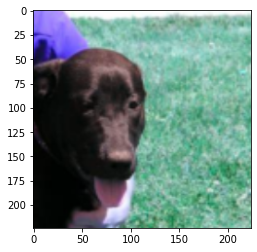

This is Dog



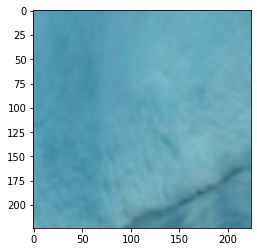

This is Cat



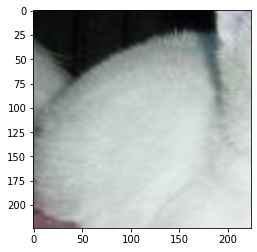

This is Cat



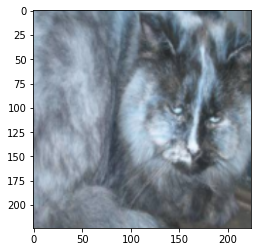

This is Cat



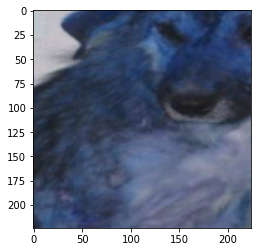

This is Dog



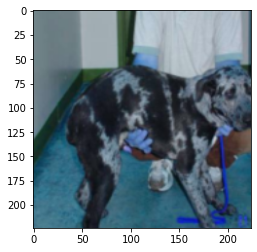

This is Dog



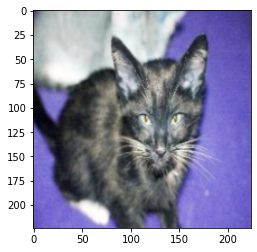

This is Cat



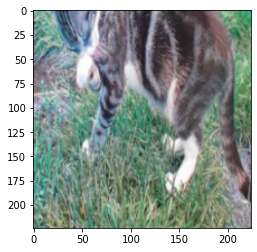

This is Dog



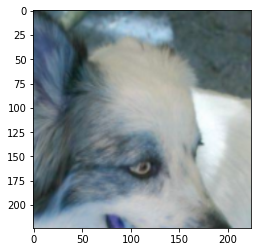

This is Dog



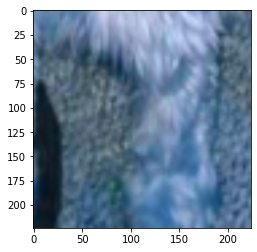

This is Dog



In [46]:
for i in range(10):
    a_img = test_imgs[i].squeeze()
    a_label = test_labels[i]
    
    # Current a_img shape is (3, 96, 96) = (channel, height, width). We need to convert it to (height, width, channel) to display the image
    a_img = np.transpose(a_img.cpu(), (1, 2, 0))
    plt.imshow(a_img)
    plt.show()

    if preds[i].item() == 1:
        DogOrCat = 'Dog'
    else:
        DogOrCat = 'Cat'

    print(f"This is {DogOrCat}")
    print("")
